In [ ]:
def plot_img(img,cmap='rgb',title):
  if cmap == 'gray': plt.imshow(img,cmap=cmap)
  else: plt.imshow(img)
  plt.title(title)
  plt.show()

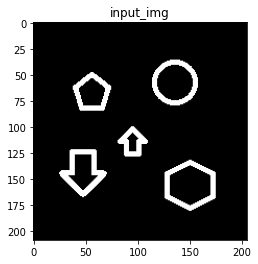

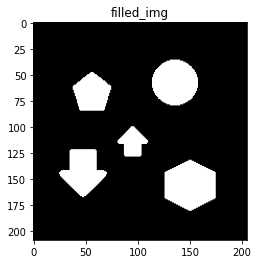

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
# Read image
im_in = cv2.imread("assets/5objects.png",0)
# Threshold.
# Set values equal to or above 220 to 0. Set values below 220 to 255. 
th, im_th = cv2.threshold(im_in, 150, 255, cv2.THRESH_BINARY)
# Copy the thresholded image. 
im_floodfill = im_th.copy()
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image. 
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
# Floodfill from point (0, 0) 


cv2.floodFill(im_floodfill, mask, (50,75), 255) # pentagon 
cv2.floodFill(im_floodfill, mask, (140,60), 255) # circle
cv2.floodFill(im_floodfill, mask, (50,150), 255) # down arrow
cv2.floodFill(im_floodfill, mask, (150,160), 255) # hexagon
cv2.floodFill(im_floodfill, mask, (95,120), 255) # up arraow

plot_img(im_in,'gray','input_img')
plot_img(im_floodfill,'gray','filled_img')

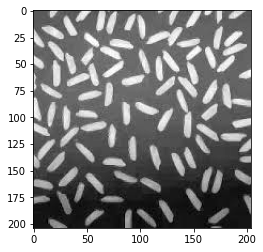

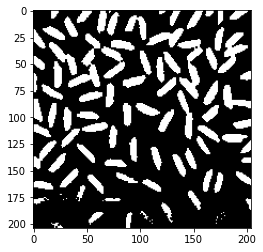

30683


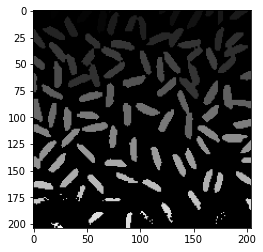

98


In [ ]:
import skimage.segmentation as seg
import skimage.filters as filters

img = cv2.imread("assets/bacteria.png",0)
plt.imshow(img,cmap='gray')
plt.show()


kernel = np.ones((1,1),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
kernel = np.ones((2,2),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)




threshold = filters.threshold_otsu(img)
ret,thresh1 = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)

plt.imshow(thresh1,cmap='gray')
plt.show()
connectivity = 4
output = cv2.connectedComponentsWithStats(thresh1, connectivity, cv2.CV_32S)
num_labels = output[0]-1
labels = output[1]
stats = output[2]
centroids = output[3]

print(stats[0,cv2.CC_STAT_AREA])
plt.imshow(labels,cmap='gray')
plt.show()
print(num_labels)
# print(  len([ e for i in range(1,len(stats)) for e in [stats[i,cv2.CC_STAT_AREA] ] if e > 1]) )


3.1) Explain your method
<br>เมื่อพิจารณาจากรูปที่ได้ ก็เริ่มจากการใช้ median filtering ในการ denoise 
<br>หลังจากนั้นทำการ thresholding โดยใช้ Otsu Thresholding
<br>ทำการ dilation เพื่อขยายขนาดของ spore เเละปิดพวก noise เล็กๆตามตัว spore ให้มีความเป็น connected component
<br>ทำการหา distancing โดยใช้ Euclidean distance (L2) เเละ ทำ thresholding อีกครั้งเพื่อหา foreground 
<br>จากนั้นนำ foreground ดังกล่าวมาคำนวณหา connected component จะได้ marker ออกมา
<br> set ส่วนที่ไม่ใช่ foreground ให้เป็น 0 ใน marker
<br> หา watershade
<br> จำนวน spore = จำนวน unique labels จาก watershade ลบด้วย 1 (background) 


In [ ]:
# ref: https://stackoverflow.com/questions/53519638/improve-accuracy-of-image-processing-to-count-fungus-spores
import cv2
def spore_counter(img_path, median_kernel, dilate_kernel,dilate_iterations=5, fg_fractional=0.6,plot_imgs=False):
  img = cv2.imread(img_path,0) # read image (gray scale)
  img = cv2.medianBlur(img,median_kernel) # denoising
  _, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # OTSU_thresholding
  kernel  = np.ones(dilate_kernel,np.uint8) # dilate kernel
  dilated = cv2.dilate(thresh, kernel, iterations=dilate_iterations) # dilation
  distance  = cv2.distanceTransform(dilated,cv2.DIST_L2,5) #distancing
  fraction_foreground = fg_fractional # fg
  _, fg = cv2.threshold(distance,fraction_foreground*distance.max(),255,0) # fg_threshold
  _, cc = cv2.connectedComponents(fg.astype(np.uint8)) # connected_component
  markers = cc+1
  subtracted = cv2.subtract(dilated,fg.astype(np.uint8)) # fg_subtraction
  markers[subtracted==np.max(subtracted)] = 0 #set subtracted_region to zero
  from skimage.segmentation import watershed # https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed
  # skimage.segmentation.watershed(image, markers=None, connectivity=1, offset=None, mask=None, compactness=0, watershed_line=False)
  watershedx = watershed(-distance,markers,watershed_line=False) # watershed ,If watershed_line is True, a one-pixel wide line separates the regions obtained by the watershed algorithm. The line has the label 0.

  # plot images for visualization
  if plot_imgs:
    plot_img(img,'gray','input_img')
    plot_img(thresh,'gray','thresholded')
    plot_img(dilated,'gray','dilated')
    plot_img(distance,'gray','distance')
    plot_img(fg,'gray','foreground')
    plot_img(subtracted,'gray','subtracted')
    plot_img(cc,'rgb','connected_components')
    plot_img(markers,'rgb','markers')
    plot_img(watershedx,'rgb','watersheds')
 
  return len(set(watershedx.flatten()))-1  # count the watershed and ignore bg


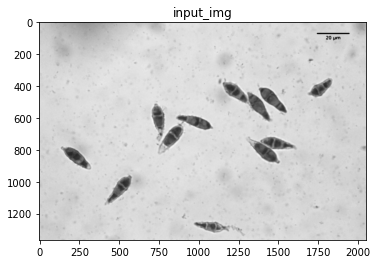

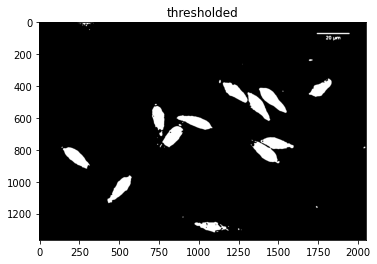

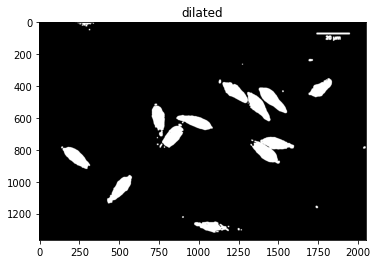

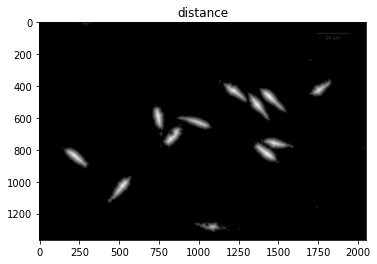

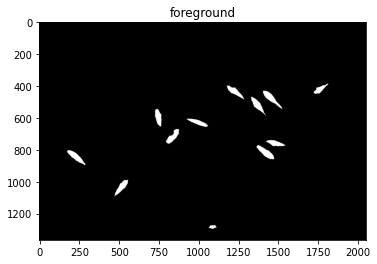

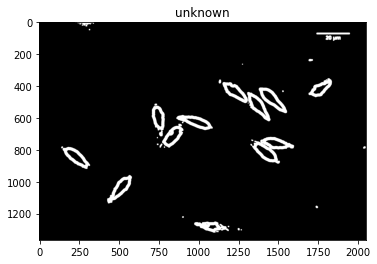

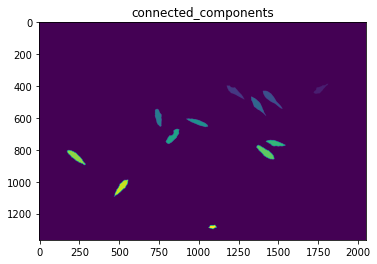

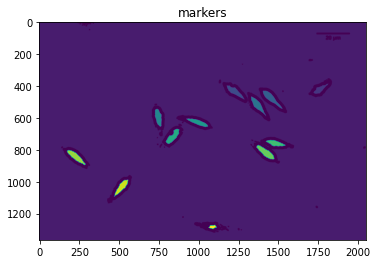

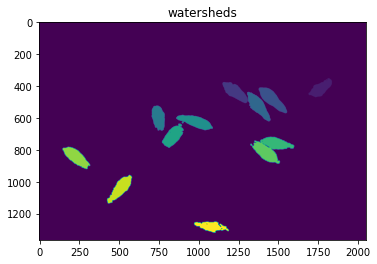

predict : 12 spores


In [ ]:
img_path = 'assets/spore1.jpg' 
median_kernel = 7; dilate_kernel= (3,3);dilate_iterations=2; fg_fractional=0.5; plot_imgs = True
print( f"predict : {spore_counter(img_path,median_kernel,dilate_kernel,dilate_iterations,fg_fractional,plot_imgs) } spores")

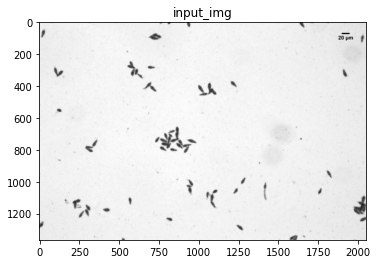

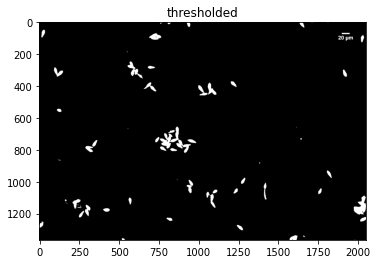

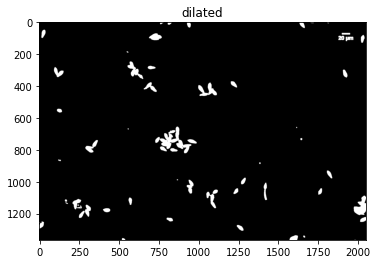

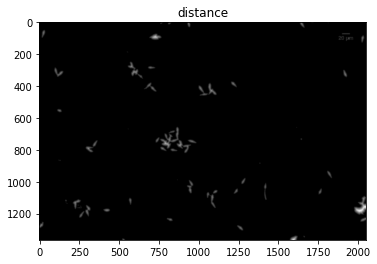

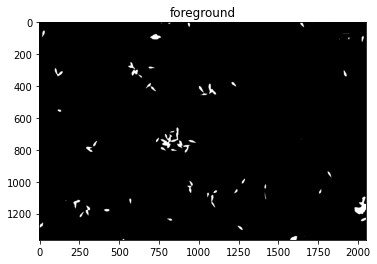

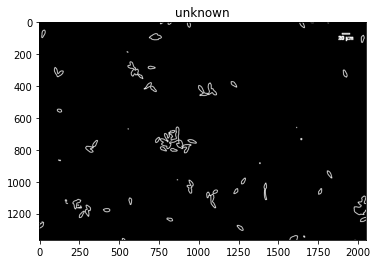

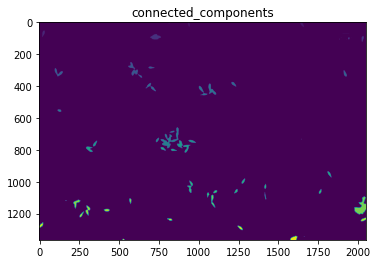

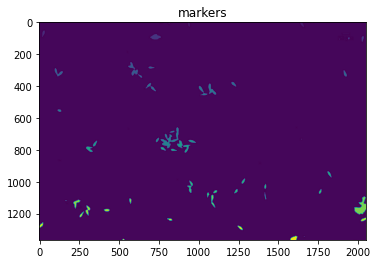

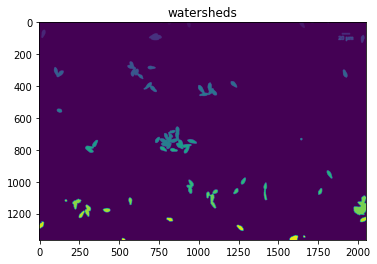

predict : 63 spores


In [ ]:
img_path = 'assets/spore2.jpg' 
median_kernel = 3; dilate_kernel= (2,2);dilate_iterations=3; fg_fractional=0.2; plot_imgs = True
print( f"predict : {spore_counter(img_path,median_kernel,dilate_kernel,dilate_iterations,fg_fractional,plot_imgs) } spores")

3.1) Explain your method
<br>เมื่อพิจารณาจากรูปที่ได้ ก็เริ่มจากการใช้ median filtering ในการ denoise 
<br>หลังจากนั้นทำการ thresholding โดยใช้ Otsu Thresholding
<br>ทำการ dilation เพื่อขยายขนาดของ spore เเละปิดพวก noise เล็กๆตามตัว spore ให้มีความเป็น connected component
<br>ทำการหา distancing โดยใช้ Euclidean distance (L2) เเละ ทำ thresholding อีกครั้งเพื่อหา foreground 
<br>จากนั้นนำ foreground ดังกล่าวมาคำนวณหา connected component จะได้ marker ออกมา
<br> set ส่วนที่ไม่ใช่ foreground ให้เป็น 0 ใน marker
<br> หา watershade
<br> จำนวน spore = จำนวน unique labels จาก watershade ลบด้วย 1 (background) 



3.2) How do you measure the performance?
<br> ใช้ accuracy เป็น metric ในการนับ

In [ ]:
def acc(predicted,gt):
  return    ( gt - abs(gt-predicted) ) / gt

3.3) What is your performance?

In [ ]:
# for exercise2:
print(f"acc for bacteria.png: {acc(98,100)}")
print(f"acc for exercise2.jpg:  { acc(12,12)}")
print(f"acc for exercise2.jpg:  { acc(63,72)}")

acc for bacteria.png: 0.98
acc for exercise2.jpg:  1.0
acc for exercise2.jpg:  0.875
